# **Impact Assessment**

### Import processing and prepping libraries

In [1]:
#import data processing libraries
import pandas as pd
import numpy as np
import psycopg2
import pymysql
import datetime as dt
from datetime import timedelta
import os
import math as math
from scipy import stats

#import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

import joblib
import pyarrow as pa
import pickle
from umap import UMAP

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load the Data

In [3]:
# repayments = pd.read_csv("../data/interim/repayments_by_different_milestones_2.csv")
# repayments.to_parquet('../data/interim/repayments_by_different_milestones_2.parquet', index=False)

In [4]:
repayments = pd.read_parquet('../data/interim/repayments_by_different_milestones_2.parquet')

repayments['store_number'] = repayments['store_number'].astype(str)

repayments.head(3)

,loan_surrogate_id,loan_mifos_id,store_number,principal_disbursed,term_frequency,repayment_amount_by_due_date,repayment_amount_by_rllvr_date,repayment_amount_by_dpd30
0,4479056,82622,7497233,4000.000,7,4104.000,4104.000,4104.000
1,4529521,42073,7073825,4000.000,7,4104.000,4104.000,4104.000
2,4523386,42131,7246325,6100.000,7,6258.600,6258.600,6258.600


In [5]:
repayments = repayments[(repayments['term_frequency'] == 7) | (repayments['term_frequency'] == 21)]

In [6]:
repayments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267782 entries, 0 to 293242
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_surrogate_id               267782 non-null  int64  
 1   loan_mifos_id                   267782 non-null  int64  
 2   store_number                    267782 non-null  object 
 3   principal_disbursed             267782 non-null  float64
 4   term_frequency                  267782 non-null  int64  
 5   repayment_amount_by_due_date    217559 non-null  float64
 6   repayment_amount_by_rllvr_date  240348 non-null  float64
 7   repayment_amount_by_dpd30       250145 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 18.4+ MB


In [7]:
repayments['repayment_amount_by_due_date'] = repayments['repayment_amount_by_due_date'].fillna(0)
repayments['repayment_amount_by_rllvr_date'] = repayments['repayment_amount_by_rllvr_date'].fillna(0)
repayments['repayment_amount_by_dpd30'] = repayments['repayment_amount_by_dpd30'].fillna(0)

In [8]:
repayments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267782 entries, 0 to 293242
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_surrogate_id               267782 non-null  int64  
 1   loan_mifos_id                   267782 non-null  int64  
 2   store_number                    267782 non-null  object 
 3   principal_disbursed             267782 non-null  float64
 4   term_frequency                  267782 non-null  int64  
 5   repayment_amount_by_due_date    267782 non-null  float64
 6   repayment_amount_by_rllvr_date  267782 non-null  float64
 7   repayment_amount_by_dpd30       267782 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 18.4+ MB


In [9]:
repayments['repayment_rate_by_due_date'] = round(repayments['repayment_amount_by_due_date'] / repayments['principal_disbursed'], 4)
repayments['repayment_rate_by_rllvr_date'] = round(repayments['repayment_amount_by_rllvr_date'] / repayments['principal_disbursed'], 4)
repayments['repayment_rate_by_dpd30'] = round(repayments['repayment_amount_by_dpd30'] / repayments['principal_disbursed'], 4)

repayments.head(3)

,loan_surrogate_id,loan_mifos_id,store_number,principal_disbursed,term_frequency,repayment_amount_by_due_date,repayment_amount_by_rllvr_date,repayment_amount_by_dpd30,repayment_rate_by_due_date,repayment_rate_by_rllvr_date,repayment_rate_by_dpd30
0,4479056,82622,7497233,4000.000,7,4104.000,4104.000,4104.000,1.026,1.026,1.026
1,4529521,42073,7073825,4000.000,7,4104.000,4104.000,4104.000,1.026,1.026,1.026
2,4523386,42131,7246325,6100.000,7,6258.600,6258.600,6258.600,1.026,1.026,1.026


In [10]:
hurdle_rate_by_due_date = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_due_date'].mean()
hurdle_rate_by_due_date = hurdle_rate_by_due_date.rename(columns={'repayment_rate_by_due_date':'hurdle_rate_by_due_date_mean'})

hurdle_rate_by_rllvr_date = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_rllvr_date'].mean()
hurdle_rate_by_rllvr_date = hurdle_rate_by_rllvr_date.rename(columns={'repayment_rate_by_rllvr_date':'hurdle_rate_by_end_rollover_date_mean'})

hurdle_rate_by_dpd30 = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_dpd30'].mean()
hurdle_rate_by_dpd30 = hurdle_rate_by_dpd30.rename(columns={'repayment_rate_by_dpd30':'hurdle_rate_by_dpd30_mean'})

hurdle_rates_df = pd.merge(hurdle_rate_by_due_date, hurdle_rate_by_rllvr_date, on='store_number', how='outer')
hurdle_rates_df = pd.merge(hurdle_rates_df, hurdle_rate_by_dpd30, on='store_number', how='outer')

hurdle_rates_df = hurdle_rates_df.fillna(0)

hurdle_rates_df.head(3)

,store_number,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,105295,1.087,1.087,1.087
1,105570,0.000,0.000,0.000
2,105652,0.842,0.842,0.969


In [12]:
current_refresh = pd.read_parquet("../data/interim/Limits_refresh_summary_20230914_multiple_products.parquet")

# del current_refresh['hurdle_rate_by_due_date_mean']
# del current_refresh['hurdle_rate_by_end_rollover_date_mean']
# del current_refresh['hurdle_rate_by_dpd30_mean']

current_refresh.rename(columns={'hurdle_rate_by_due_date_mean': 'hurdle_rate_by_due_date_mean_refresh', 
                                'hurdle_rate_by_end_rollover_date_mean': 'hurdle_rate_by_end_rollover_date_mean_refresh', 
                                'hurdle_rate_by_dpd30_mean': 'hurdle_rate_by_dpd30_mean_refresh'}, inplace=True)

current_refresh['store_number'] = current_refresh['store_number'].astype(str)

current_refresh.head(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,hurdle_rate_by_due_date_mean_refresh,hurdle_rate_by_end_rollover_date_mean_refresh,hurdle_rate_by_dpd30_mean_refresh,opt_in_date,model_version,created_at
0,254723778344,7606765,373123.950,2023-08-15,2023-09-13,30,30,1.000,relax_rules,0.000,Yes,1.000,23908954,Approve,NaN,True,True,254723778344,1,600.000,7.000,30000.000,30000.000,2023-09-04,2023-09-11,2023-09-11,2023-09-11,0.000,2.000,closed_on_time,458.000,30000.000,2023-09-04,1.000,1.000,9.000,1,1,1.031,1,1,NaN,1,pass,93300,30000,63300,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 2,0.250,0.150,0.150,1.000,1.000,1,1.000,0.250,0.150,0.150,93280.988,55968.592,55968.592,93280.988,55968.592,55968.592,93300,45000,0,0,0,0,30000,0,1.031,1.031,1.031,2022-07-07,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35
1,254723635919,7051927,51450.000,2023-08-16,2023-09-13,29,28,0.970,relax_rules,0.000,Yes,1.000,23607603,Approve,0.000,True,True,254723635919,3,300.000,7.000,6000.000,3812.800,2023-09-08,2023-09-15,NaT,2023-09-15,-2.000,2.000,current_active,458.000,6000.000,2023-09-08,3.000,1.000,5.000,1,3,1.031,1,1,NaN,1,pass,15500,6200,9300,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 3,0.300,0.175,0.175,1.000,1.000,1,1.000,0.300,0.175,0.150,15435.000,9003.750,7717.500,15435.000,9003.750,7717.500,15500,7800,0,0,0,0,6200,0,1.031,1.031,1.031,2022-08-25,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35


In [13]:
current_refresh = pd.merge(current_refresh, hurdle_rates_df, on='store_number', how='left')

current_refresh.head(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,hurdle_rate_by_due_date_mean_refresh,hurdle_rate_by_end_rollover_date_mean_refresh,hurdle_rate_by_dpd30_mean_refresh,opt_in_date,model_version,created_at,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,254723778344,7606765,373123.950,2023-08-15,2023-09-13,30,30,1.000,relax_rules,0.000,Yes,1.000,23908954,Approve,NaN,True,True,254723778344,1,600.000,7.000,30000.000,30000.000,2023-09-04,2023-09-11,2023-09-11,2023-09-11,0.000,2.000,closed_on_time,458.000,30000.000,2023-09-04,1.000,1.000,9.000,1,1,1.031,1,1,NaN,1,pass,93300,30000,63300,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 2,0.250,0.150,0.150,1.000,1.000,1,1.000,0.250,0.150,0.150,93280.988,55968.592,55968.592,93280.988,55968.592,55968.592,93300,45000,0,0,0,0,30000,0,1.031,1.031,1.031,2022-07-07,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35,1.031,1.031,1.031
1,254723635919,7051927,51450.000,2023-08-16,2023-09-13,29,28,0.970,relax_rules,0.000,Yes,1.000,23607603,Approve,0.000,True,True,254723635919,3,300.000,7.000,6000.000,3812.800,2023-09-08,2023-09-15,NaT,2023-09-15,-2.000,2.000,current_active,458.000,6000.000,2023-09-08,3.000,1.000,5.000,1,3,1.031,1,1,NaN,1,pass,15500,6200,9300,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 3,0.300,0.175,0.175,1.000,1.000,1,1.000,0.300,0.175,0.150,15435.000,9003.750,7717.500,15435.000,9003.750,7717.500,15500,7800,0,0,0,0,6200,0,1.031,1.031,1.031,2022-08-25,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35,1.031,1.031,1.031


In [14]:
##############################
current_refresh['days_since_last_trx'] = current_refresh['days_since_last_trx'].fillna(31)

In [15]:
current_refresh[['final_21_limit', 'final_7_limit', 'final_1_limit']].sum()

final_21_limit    224807200
final_7_limit     189116700
final_1_limit             0
dtype: int64

In [16]:
# Load artifacts
with open('../models/clf_scaler_model.pkl', "rb") as f:
    clf_scaling = pickle.load(f)

# with open(project_dir + clf_dim_reduction_path, "rb") as f:
#     clf_dim_reduction = pickle.load(f)

with open('../models/decision_tree_model.pkl', "rb") as f:
    clf_model = pickle.load(f)

In [17]:
nbfis = ["approx_30_days_trx_val", "page_active_days", "days_since_last_trx", "weight_recency", "weight_consistency", "actual_trx_days"]
current_refresh["predicted_cluster"] = clf_model.predict(clf_scaling.transform(current_refresh[nbfis]))
current_refresh.sample(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,hurdle_rate_by_due_date_mean_refresh,hurdle_rate_by_end_rollover_date_mean_refresh,hurdle_rate_by_dpd30_mean_refresh,opt_in_date,model_version,created_at,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean,predicted_cluster
11327,254792495024,7234240,0.000,2023-09-03,2023-09-03,1,1,1.000,No_rules_relaxed,10.000,No,0.000,34663925,Reject,0.000,True,False,254792495024,1,300.000,1.000,300.000,0.000,2022-06-18,2022-06-19,NaT,2022-06-19,451.000,2.000,active_default,449.000,300.000,2022-06-18,0.000,0.000,452.000,0,0,0.000,0,0,0.000,0,fail,0,0,0,0.350,0.120,0.120,0.700,0.706,0.706,Band 7,Band 1,0.200,0.125,0.125,0.000,1.000,0,0.250,0.035,0.022,0.022,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,1,0,0,0,0,0.000,0.000,0.000,2022-01-24,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35,NaN,NaN,NaN,3
56700,254708219221,7694898,31500.000,2023-08-15,2023-09-13,30,30,1.000,No_rules_relaxed,0.000,Yes,1.000,30054222,Reject,0.000,True,False,None,0,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,0.000,NaN,None,NaN,NaN,NaT,NaN,1.000,NaN,1,0,NaN,0,0,NaN,0,fail,0,0,0,0.350,0.120,0.120,0.700,0.706,0.706,Band 7,Band 1,0.200,0.125,0.125,1.000,1.000,1,1.000,0.140,0.088,0.088,4410.000,2779.412,2779.412,0.000,2779.412,2779.412,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2022-08-29,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35,NaN,NaN,NaN,5


In [18]:
current_refresh.groupby(['predicted_cluster']).agg({'store_number': 'count'})

,store_number
predicted_cluster,
0,131
1,5353
2,478
3,6854
4,11457
5,22379
6,2808
7,9257
8,7527


In [19]:
def set_hr_flags(data, input_col, hr):
    return np.where(data[input_col] >= hr, 1, 0)

In [20]:
current_refresh['dpd30_103_milestone'] = set_hr_flags(current_refresh, 'hurdle_rate_by_dpd30_mean_refresh', 1.03)
current_refresh['dpd30_102_milestone'] = set_hr_flags(current_refresh, 'hurdle_rate_by_dpd30_mean_refresh', 1.02)
current_refresh['dpd30_100_milestone'] = set_hr_flags(current_refresh, 'hurdle_rate_by_dpd30_mean_refresh', 1.00)
current_refresh.sample(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,hurdle_rate_by_due_date_mean_refresh,hurdle_rate_by_end_rollover_date_mean_refresh,hurdle_rate_by_dpd30_mean_refresh,opt_in_date,model_version,created_at,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean,predicted_cluster,dpd30_103_milestone,dpd30_102_milestone,dpd30_100_milestone
37439,254726212556,6002746,9750.000,2023-08-15,2023-09-13,30,30,1.000,No_rules_relaxed,0.000,Yes,1.000,37322407,Reject,NaN,True,False,None,0,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,0.000,NaN,None,NaN,NaN,NaT,NaN,1.000,NaN,1,0,NaN,0,0,NaN,0,fail,0,0,0,0.350,0.120,0.120,0.700,0.706,0.706,Band 7,Band 1,0.200,0.125,0.125,1.000,1.000,1,1.000,0.140,0.088,0.088,1365.000,860.294,860.294,0.000,860.294,860.294,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2023-04-03,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35,NaN,NaN,NaN,5,0,0,0
65510,254790788116,7304732,174825.000,2023-08-15,2023-09-13,30,30,1.000,No_rules_relaxed,0.000,Yes,1.000,28932928,Reject,0.000,True,False,None,0,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,0.000,NaN,None,NaN,NaN,NaT,NaN,1.000,NaN,1,0,NaN,0,0,NaN,0,fail,15500,15500,0,0.350,0.120,0.120,0.700,0.706,0.706,Band 7,Band 1,0.200,0.125,0.125,1.000,1.000,1,1.000,0.140,0.088,0.088,24475.500,15425.735,15425.735,0.000,15425.735,15425.735,15500,15500,0,0,0,0,15500,0,NaN,NaN,NaN,2021-11-05,"2023-014[2023-09-01, 2023-09-14]",2023-09-14 10:03:35,NaN,NaN,NaN,4,0,0,0


In [21]:
# selected_columns = current_refresh[["store_number", "approx_30_days_trx_val", "expected_trx_days", "actual_trx_days", "page_active_days", "days_since_last_trx", "weight_consistency", "weight_recency", "hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]]
selected_columns = current_refresh[["store_number", "hurdle_rate_by_dpd30_mean", 'predicted_cluster', 'dpd30_103_milestone', 'dpd30_102_milestone', 'dpd30_100_milestone', 
                                    'hurdle_rate_by_due_date_mean_refresh', 'hurdle_rate_by_end_rollover_date_mean_refresh', 'hurdle_rate_by_dpd30_mean_refresh'] + nbfis]

selected_columns.head(2)

,store_number,hurdle_rate_by_dpd30_mean,predicted_cluster,dpd30_103_milestone,dpd30_102_milestone,dpd30_100_milestone,hurdle_rate_by_due_date_mean_refresh,hurdle_rate_by_end_rollover_date_mean_refresh,hurdle_rate_by_dpd30_mean_refresh,approx_30_days_trx_val,page_active_days,days_since_last_trx,weight_recency,weight_consistency,actual_trx_days
0,7606765,1.031,1,1,1,1,1.031,1.031,1.031,373123.950,1.000,0.000,1,1.000,30
1,7051927,1.031,5,1,1,1,1.031,1.031,1.031,51450.000,0.970,0.000,1,1.000,28


In [22]:
selected_columns.shape

(66244, 15)

In [23]:
without_performance_data = selected_columns[selected_columns['hurdle_rate_by_dpd30_mean'].isnull()].reset_index(drop=True)
print(without_performance_data.shape)
with_performance_data = selected_columns[selected_columns['hurdle_rate_by_dpd30_mean'].notnull()].reset_index(drop=True)
print(with_performance_data.shape)

(33831, 15)
(32413, 15)


In [24]:
with_performance_data[with_performance_data['hurdle_rate_by_dpd30_mean'] >= 1.03].shape

(11131, 15)

In [25]:
(11704/32082) * 100

36.481516114955426

In [26]:
with_performance_data.groupby(['predicted_cluster']).agg({'store_number': 'count', 
                                                          'hurdle_rate_by_due_date_mean_refresh': 'median', 
                                                          'hurdle_rate_by_end_rollover_date_mean_refresh': 'median', 
                                                          'hurdle_rate_by_dpd30_mean_refresh': 'median', 
                                                          'dpd30_103_milestone': 'sum'})

,store_number,hurdle_rate_by_due_date_mean_refresh,hurdle_rate_by_end_rollover_date_mean_refresh,hurdle_rate_by_dpd30_mean_refresh,dpd30_103_milestone
predicted_cluster,,,,,
0,64,0.913,1.031,1.032,42
1,2426,0.882,1.005,1.031,1325
2,237,0.915,1.023,1.031,141
3,5984,0.684,0.821,0.912,1641
4,4104,0.825,0.965,1.027,1930
5,5832,0.776,0.930,1.002,2466
6,2474,0.687,0.829,0.933,732
7,8227,0.677,0.780,0.884,1782
8,3065,0.725,0.879,0.968,1102


In [27]:
summaries = with_performance_data.copy()

In [28]:
nbfis

['approx_30_days_trx_val',
 'page_active_days',
 'days_since_last_trx',
 'weight_recency',
 'weight_consistency',
 'actual_trx_days']

C:\Users\FM\anaconda3\envs\bloom\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


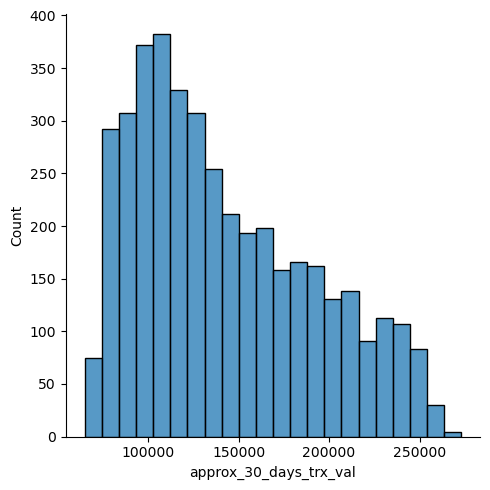

In [29]:
a = with_performance_data[(with_performance_data['predicted_cluster'] == 4) & (with_performance_data['hurdle_rate_by_dpd30_mean'] < 1.5)]
sns.displot(data=a, x='approx_30_days_trx_val')

C:\Users\FM\AppData\Local\Temp\ipykernel_10036\3063482858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['log'] = a['hurdle_rate_by_dpd30_mean']*a['hurdle_rate_by_dpd30_mean']
C:\Users\FM\anaconda3\envs\bloom\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


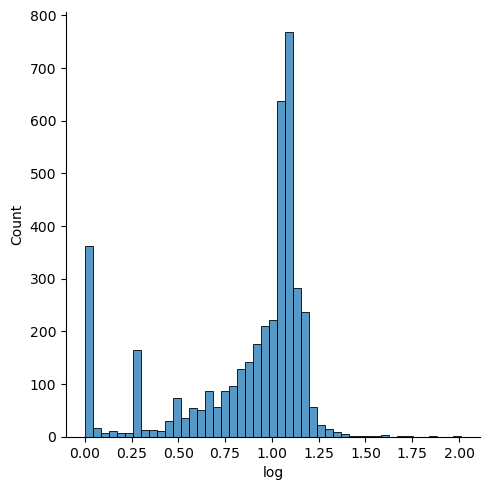

In [30]:
a['log'] = a['hurdle_rate_by_dpd30_mean']*a['hurdle_rate_by_dpd30_mean']
sns.displot(data=a, x='log')

In [31]:
a.drop(columns=['store_number', 'predicted_cluster', 'dpd30_103_milestone', 'dpd30_102_milestone', 'dpd30_100_milestone', 'hurdle_rate_by_due_date_mean_refresh', 
                'hurdle_rate_by_end_rollover_date_mean_refresh', 'hurdle_rate_by_dpd30_mean_refresh', 'log']).corr()['hurdle_rate_by_dpd30_mean'].sort_values()

page_active_days            -0.016
actual_trx_days             -0.015
days_since_last_trx         -0.007
approx_30_days_trx_val       0.021
hurdle_rate_by_dpd30_mean    1.000
weight_recency                 NaN
weight_consistency             NaN
Name: hurdle_rate_by_dpd30_mean, dtype: float64

<Axes: xlabel='log', ylabel='hurdle_rate_by_dpd30_mean'>

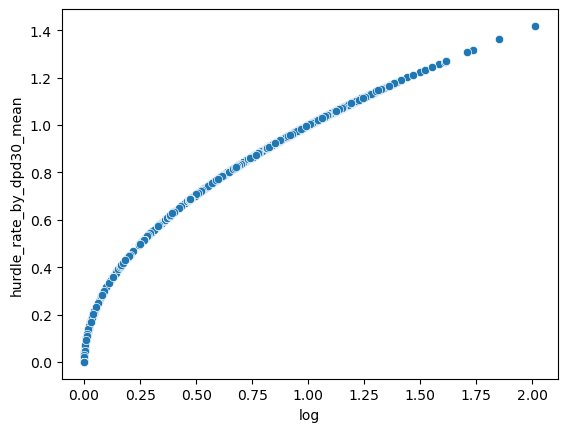

In [32]:
sns.scatterplot(data=a, x='log', y='hurdle_rate_by_dpd30_mean')

C:\Users\FM\anaconda3\envs\bloom\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


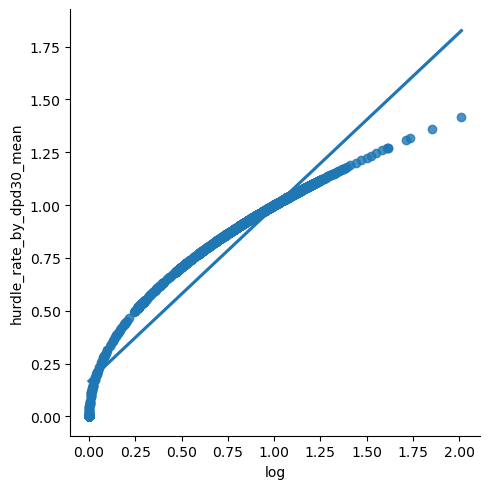

In [33]:
sns.lmplot(x='log', y='hurdle_rate_by_dpd30_mean', data=a)

Cluster in scope: 4 


Before: dpd30_103_milestone
0    2174
1    1929
Name: count, dtype: int64
After: dpd30_103_milestone
0    1929
1    1929
Name: count, dtype: int64
Sample size: (3858, 4)
Train size: (3472, 4)
Test size: (386, 4)

Variance: 0.9928030690166285

Mean Squared Error:
0.1389265768064373
0.019379373057459317

Mean Absolute Error:
0.25063486527326323
0.053376263773230556

R-squared:
-0.45005937822529907
0.7873362287365997

Adjusted R-squared:
-0.4614472791014139

HR: 1.03


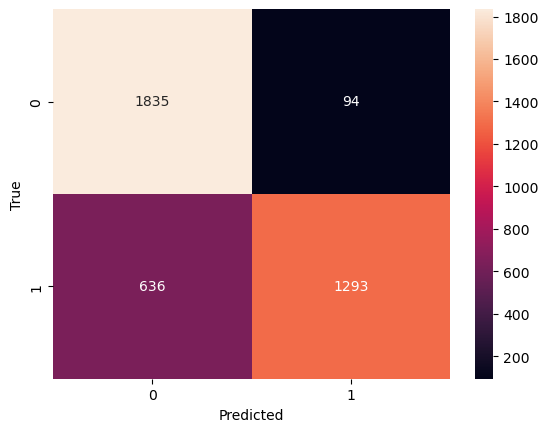


HR: 1.02


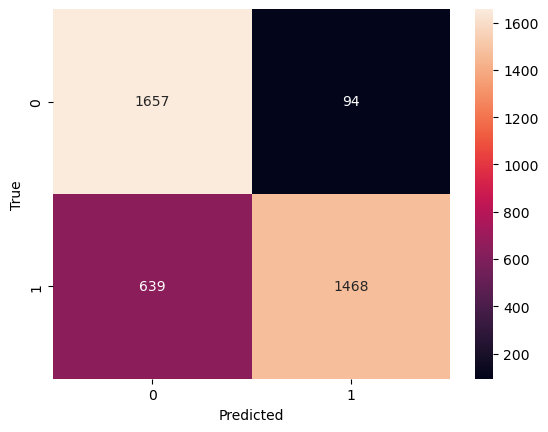


HR: 1.0


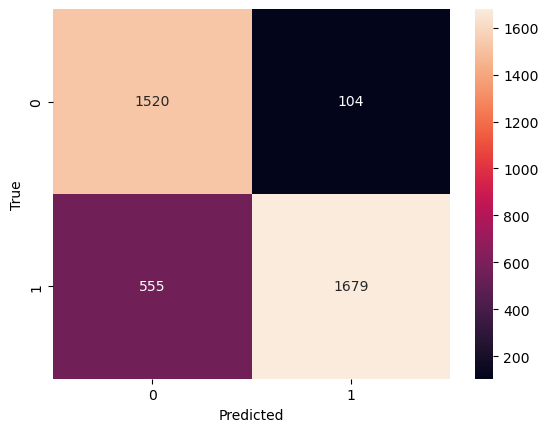


Cluster in scope: 5 


Before: dpd30_103_milestone
0    3366
1    2465
Name: count, dtype: int64
After: dpd30_103_milestone
0    2465
1    2465
Name: count, dtype: int64
Sample size: (4930, 4)
Train size: (4437, 4)
Test size: (493, 4)

Variance: 0.9347938607358248

Mean Squared Error:
0.1377120401956823
0.02630162741289828

Mean Absolute Error:
0.251129769530344
0.07509744537275741

R-squared:
-0.406147191566413
0.6921451193689651

Adjusted R-squared:
-0.4147738614533234

HR: 1.03


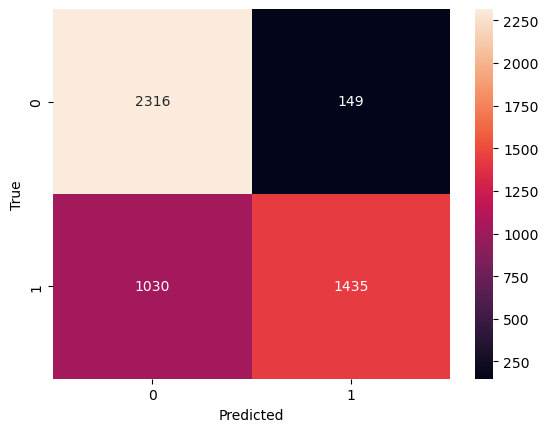


HR: 1.02


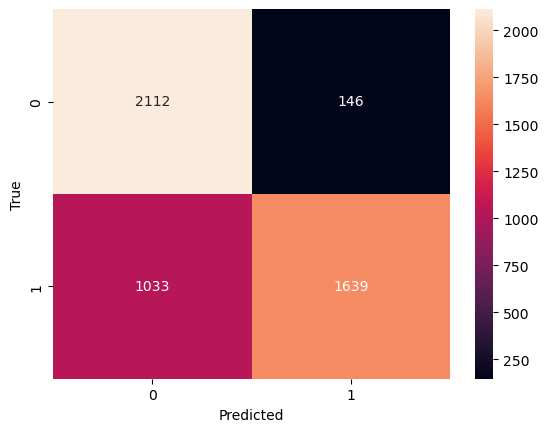


HR: 1.0


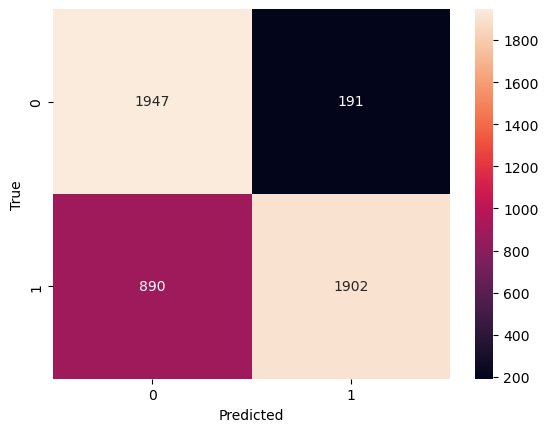


Cluster in scope: 8 


Before: dpd30_103_milestone
0    1963
1    1102
Name: count, dtype: int64
After: dpd30_103_milestone
0    1102
1    1102
Name: count, dtype: int64
Sample size: (2204, 4)
Train size: (1983, 4)
Test size: (221, 4)

Variance: 0.8951115971330966

Mean Squared Error:
0.12110520736792976
0.04088749858621332

Mean Absolute Error:
0.2447556395248989
0.0921574709074505

R-squared:
-0.2680292945536584
0.6443601782860593

Adjusted R-squared:
-0.2855596534645386

HR: 1.03


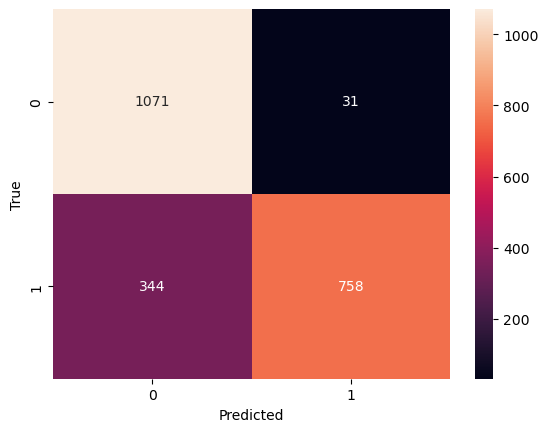


HR: 1.02


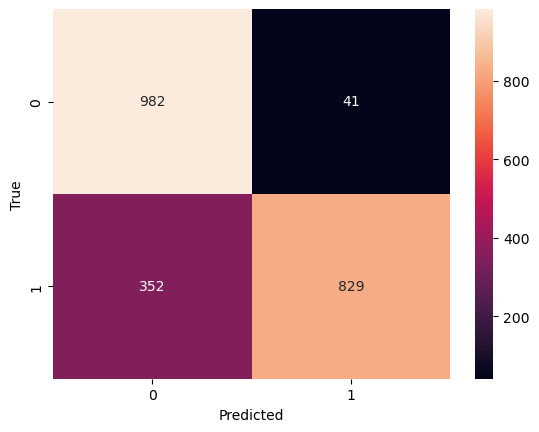


HR: 1.0


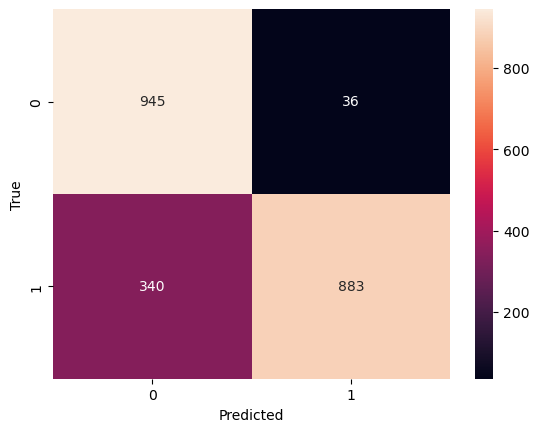

In [36]:
def make_predictions(with_performance_data, cluster_in_scope, tar):
    print('Cluster in scope:', cluster_in_scope, '\n')
    
    with_performance_data_filt = with_performance_data[(with_performance_data['predicted_cluster'] == cluster_in_scope) & 
                                                       (with_performance_data['hurdle_rate_by_dpd30_mean'] < 1.5)]
    
    # Transformations
    # with_performance_data_filt['hurdle_rate_by_dpd30_mean_transformed'] = with_performance_data_filt['hurdle_rate_by_dpd30_mean'] * with_performance_data_filt['hurdle_rate_by_dpd30_mean']
    
    ## TODO
    data = with_performance_data_filt.drop(['store_number', 'predicted_cluster', 'hurdle_rate_by_due_date_mean_refresh', 'hurdle_rate_by_end_rollover_date_mean_refresh', 
                                            'hurdle_rate_by_dpd30_mean_refresh', "weight_recency", "weight_consistency", 'dpd30_103_milestone', 'dpd30_102_milestone', 
                                            'dpd30_100_milestone'], axis=1)
    
    # fig, ax = plt.subplots(figsize=(8, 8))
    # sns.pairplot(data)
    # plt.show()
    
    print('\nBefore:', with_performance_data_filt['dpd30_103_milestone'].value_counts())
    samp = NearMiss(n_neighbors=50, version=1)
    with_performance_data_filt, _ = samp.fit_resample(with_performance_data_filt.drop(columns=['hurdle_rate_by_due_date_mean_refresh', 'hurdle_rate_by_end_rollover_date_mean_refresh', 
                                                                                               'hurdle_rate_by_dpd30_mean_refresh',]), 
                                                      with_performance_data_filt['dpd30_103_milestone'])
    print('After:', with_performance_data_filt['dpd30_103_milestone'].value_counts())
    
    # Assuming 'X' contains your independent variables (excluding the unique identifier) and 'y' contains the target variable
    X_with_performance_data = with_performance_data_filt.drop(['hurdle_rate_by_dpd30_mean', 'store_number', 'predicted_cluster',  
                                                               'dpd30_103_milestone', 'dpd30_102_milestone', 'dpd30_100_milestone', "weight_recency", "weight_consistency"], axis=1)
    y_with_performance_data = with_performance_data_filt['hurdle_rate_by_dpd30_mean']
    
    # Split the dataset into a training set and a test set (adjust the test_size as needed)
    X_train_with_performance_data, X_test_with_performance_data, y_train_with_performance_data, y_test_with_performance_data = train_test_split(X_with_performance_data, y_with_performance_data, test_size=0.1, random_state=42)
    
    # print(X_train_with_performance_data.columns)
    print('Sample size:', X_with_performance_data.shape)
    print('Train size:', X_train_with_performance_data.shape)
    print('Test size:', X_test_with_performance_data.shape)
    
    # # Upsampling
    # X_train_with_performance_data = pd.concat([X_train_with_performance_data, X_train_with_performance_data])
    # y_train_with_performance_data = pd.concat([y_train_with_performance_data, y_train_with_performance_data])
    # print('Upsampleing size:', X_train_with_performance_data.shape)
    
    # Create a StandardScaler to scale the features
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_train_scaled_with_performance_data = scaler.fit_transform(X_train_with_performance_data)
    
    with open(f"../models/scaler_model_cluster_{cluster_in_scope}.pkl", "wb") as f:
        pickle.dump(scaler, f)
    
    # Create a dim reduction to reduce the features
    dim = PCA(n_components=3)

    # Fit the dim reduction on the training data and transform it
    X_train_scaled_dim_with_performance_data = dim.fit_transform(X_train_scaled_with_performance_data)
    
    with open(f"../models/dim_model_cluster_{cluster_in_scope}.pkl", "wb") as f:
        pickle.dump(dim, f)
    
    print('\nVariance:', sum(dim.explained_variance_ratio_))
    
    # Create a Linear Regression model
    # model = LinearRegression()

    # Create a Random Forest Regression model
    # model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=42)

    # Create an XGBoost Regressor model
    # model = xgb.XGBRegressor(
    #     n_estimators=500,          # Number of boosting rounds (trees)
    #     learning_rate=0.1,         # Step size shrinkage to prevent overfitting
    #     max_depth=2,               # Maximum depth of individual trees
    #     random_state=42
    # )

    # # Create an SVR model
    # model = SVR(kernel='rbf', C=20)
    
    model = KNeighborsRegressor(n_neighbors=10, weights='distance')
    
    # Fit the model on the training data
    model.fit(X_train_scaled_dim_with_performance_data, y_train_with_performance_data)
    
    with open(f"../models/regression_model_{tar}_cluster_{cluster_in_scope}.pkl", "wb") as f:
        pickle.dump(model, f)
    
    # Transform test data - scaler
    X_test_scaled_with_performance_data = scaler.transform(X_test_with_performance_data)
    
    # Transform test data - dim
    X_test_scaled_dim_with_performance_data = dim.transform(X_test_scaled_with_performance_data)
    
    # Make predictions on the test data
    y_pred_with_performance_data = model.predict(X_test_scaled_dim_with_performance_data)
    
    # Evaluate the model
    mse = mean_squared_error(y_test_with_performance_data, y_pred_with_performance_data)
    r2 = r2_score(y_test_with_performance_data, y_pred_with_performance_data)
    mae = mean_absolute_error(y_test_with_performance_data, y_pred_with_performance_data)

    # Calculate Adjusted R-squared
    n = X_test_scaled_dim_with_performance_data.shape[0]  # Number of samples
    p = X_test_scaled_dim_with_performance_data.shape[1]  # Number of predictors (features)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Print the evaluation metrics
    print("\nMean Squared Error:\n", mse, sep='')
    print(mean_squared_error(y_train_with_performance_data, model.predict(X_train_scaled_dim_with_performance_data)))
    print("\nMean Absolute Error:\n", mae, sep='')
    print(mean_absolute_error(y_train_with_performance_data, model.predict(X_train_scaled_dim_with_performance_data)))
    print("\nR-squared:\n", r2, sep='')
    print(r2_score(y_train_with_performance_data, model.predict(X_train_scaled_dim_with_performance_data)))
    print("\nAdjusted R-squared:\n", adjusted_r2, sep='')
    
    # plt.scatter(y_train_with_performance_data, model.predict(X_train_scaled_dim_with_performance_data))
    # plt.show()
    
    with_performance_data_filt['hurdle_rate_by_dpd30_mean_predicted'] = model.predict(dim.transform(scaler.transform(X_with_performance_data)))
    
    for hr in [1.03, 1.02, 1.00]:
        print('\nHR:', hr)
        
        with_performance_data_filt[f'hurdle_rate_by_dpd30_mean_predicted_{int(hr*100)}_milestone'] = set_hr_flags(with_performance_data_filt, 'hurdle_rate_by_dpd30_mean_predicted', hr)
        
        cm = confusion_matrix(with_performance_data_filt[f'dpd30_{int(hr*100)}_milestone'], with_performance_data_filt[f'hurdle_rate_by_dpd30_mean_predicted_{int(hr*100)}_milestone'])
        sns.heatmap(cm, annot=True, fmt='.0f')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    print('=========================================================================================\n')

c = [4, 5, 8]
t = ['dpd30'] * len(c)
for cluster, tar in zip(c, t):
    make_predictions(with_performance_data, cluster, tar)

In [ ]:
def non_linear_fit(with_performance_data, cluster_in_scope, tar):
    with_performance_data_filt = with_performance_data[(with_performance_data['predicted_cluster'] == cluster_in_scope) & 
                                                       (with_performance_data['hurdle_rate_by_dpd30_mean'] < 1.5)]
    
    # Assuming 'X' contains your independent variables (excluding the unique identifier) and 'y' contains the target variable
    X_with_performance_data = with_performance_data_filt.drop(['hurdle_rate_by_dpd30_mean', 'store_number', 'predicted_cluster', 'hurdle_rate_by_due_date_mean_refresh', 
                                                               'hurdle_rate_by_end_rollover_date_mean_refresh', 'hurdle_rate_by_dpd30_mean_refresh', "weight_recency", 
                                                               "weight_consistency"], axis=1)
    y_with_performance_data = with_performance_data_filt['hurdle_rate_by_dpd30_mean']
    
    # Split the dataset into a training set and a test set (adjust the test_size as needed)
    X_train_with_performance_data, X_test_with_performance_data, y_train_with_performance_data, y_test_with_performance_data = train_test_split(X_with_performance_data, y_with_performance_data, test_size=0.2, random_state=42)
    
    print('Cluster in scope:', cluster_in_scope, '\n')
    # print(X_train_with_performance_data.columns)
    print('Sample size:', X_with_performance_data.shape)
    print('Train size:', X_train_with_performance_data.shape)
    print('Test size:', X_test_with_performance_data.shape)
    
    # Create a StandardScaler to scale the features
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_train_scaled_with_performance_data = scaler.fit_transform(X_train_with_performance_data)
    
    with open(f"../models/scaler_model_cluster_{cluster_in_scope}.pkl", "wb") as f:
        pickle.dump(scaler, f)
    
    # Create a dim reduction to reduce the features
    dim = PCA(n_components=3)

    # Fit the dim reduction on the training data and transform it
    X_train_scaled_dim_with_performance_data = dim.fit_transform(X_train_scaled_with_performance_data)
    
    with open(f"../models/dim_model_cluster_{cluster_in_scope}.pkl", "wb") as f:
        pickle.dump(dim, f)
    
    print('Variance:', sum(dim.explained_variance_ratio_))
    
    degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    for degree in degrees:
        print('\nDegree in scope:', degree, '\n')
        
        pipeline = Pipeline([('poly_features', PolynomialFeatures(degree=degree)),
                         ('model', RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42))])
        pipeline.fit(X_train_scaled_dim_with_performance_data, y_train_with_performance_data)
        
        # Transform test data - scaler
        X_test_scaled_with_performance_data = scaler.transform(X_test_with_performance_data)

        # Transform test data -dim
        X_test_scaled_dim_with_performance_data = dim.transform(X_test_scaled_with_performance_data)
    
        # Transform test data - scaler
        X_test_scaled_with_performance_data = scaler.transform(X_test_with_performance_data)

        # Transform test data -dim
        X_test_scaled_dim_with_performance_data = dim.transform(X_test_scaled_with_performance_data)

        # Make predictions on the test data
        y_pred_with_performance_data = pipeline.predict(X_test_scaled_dim_with_performance_data)

        # Evaluate the model
        mse = mean_squared_error(y_test_with_performance_data, y_pred_with_performance_data)
        r2 = r2_score(y_test_with_performance_data, y_pred_with_performance_data)
        mae = mean_absolute_error(y_test_with_performance_data, y_pred_with_performance_data)

        # Calculate Adjusted R-squared
        n = X_test_scaled_dim_with_performance_data.shape[0]  # Number of samples
        p = X_test_scaled_dim_with_performance_data.shape[1]  # Number of predictors (features)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        # Print the evaluation metrics
        print("Mean Squared Error:", mse)
        print(mean_squared_error(y_train_with_performance_data, pipeline.predict(X_train_scaled_dim_with_performance_data)))
        print("Mean Absolute Error:", mae)
        print(mean_absolute_error(y_train_with_performance_data, pipeline.predict(X_train_scaled_dim_with_performance_data)))
        print("R-squared:", r2)
        print(r2_score(y_train_with_performance_data, pipeline.predict(X_train_scaled_dim_with_performance_data)))
        print("Adjusted R-squared:", adjusted_r2)

    print('=========================================================================================\n')

c = [4, 5, 8]
t = ['dpd30'] * len(c)
for cluster, tar in zip(c, t):
    non_linear_fit(with_performance_data, cluster, tar)

In [ ]:
without_performance_data.shape

In [ ]:
without_performance_data.sample(2)

In [ ]:
# Assuming 'X' contains your independent variables (excluding the unique identifier) for 'without_performance_data'
X_without_performance_data = without_performance_data.drop(['hurdle_rate_by_dpd30_mean', 'store_number'], axis=1)

# Scale the features using the same scaler used for the 'with_performance_data' dataset
X_scaled_without_performance_data = scaler.transform(X_without_performance_data)

# Make predictions on the 'without_performance_data' dataset
y_pred_without_performance_data = model.predict(X_scaled_without_performance_data)

# Add the predictions to the 'without_performance_data' DataFrame
without_performance_data['hurdle_rate_by_dpd30_mean'] = y_pred_without_performance_data

In [ ]:
without_performance_data.head()

In [ ]:
without_performance_data.shape

In [ ]:
without_performance_data['hurdle_rate_by_dpd30_mean'].describe()

In [ ]:
without_performance_data[without_performance_data['hurdle_rate_by_dpd30_mean'] >= 1.03].shape